# Quickstart guide for ALBATROS directly-computed spectra

Requires scio to read data. Install scio with pip.
~~~
pip install pbio
~~~

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scio import scio

## Key information about the data

* Frequency span: 0-125 MHz
* Number of channels: 2048
* Frequency resolution: 125 MHz / 2048 = 61.0 kHz
* Sampling rate: 250 Msamples/s
* Accumulation time: ~6.44 s

#### Hydroshack Overwinter 2021 details
* 1 dual-polarization LWA antenna
* Antenna coordinates: S 46° 52’ 12.1", E 37° 50’ 35.0”, elevation 76m
* pol0 orientation: EW
* pol1 orientation: NS


### Data products
* pol00.scio.bz2: pol0 data auto-correlated with itself
* pol11.scio.bz2: pol1 data auto-correlated with itself
* pol01r.scio.bz2: pol0 cross-correlated with pol1 (real part)
* pol01i.scio.bz2: pol0 cross-correlated with pol1 (imaginary part)

#### Auxiliary data products
* fpga_temp.raw: FPGA temperature
* pi_temp.raw: Raspberry Pi temperature
* time_sys_start.raw: Timestamp (from Raspberry Pi) when reading a row of accumulated data from FPGA registers is started.
* time_sys_stop.raw: Timestamp (from Raspberry Pi) when done reading FPGA registers.
* time_gps_start.raw: Timestamp (from GPS) when reading a row of accumulated data from FPGA registers is started.
* time_gps_stop.raw: Timestamp (from GPS) when done reading FPGA registers.
* acc_cnt[12].raw: accumulation counter
* pfb_fft_of[12].raw: PFB FFT overflow counter
* sync_cnt[12].raw: some FPGA-related counter

### Data structure

The directly-computed spectra data is found in the `data_auto_cross/` directory and is organized into subdirectories by Unix timestamp.

At the lowest level, the data files (pol00.scio, fpga_temp.raw, etc.) are contained within a subdirectory named according to the timestamp at the start time of the data acquisition. During long observation runs, a new subdirectory of this type is created every hour. With an accumulation time of 6.44s, there are 560 rows of data (may vary by +/-1 sometimes) in a regular hour-long direct spectra file.

These subdirectories are contained within directories named using the first 5 digits of the timestamp. For example, `1640100000/` would be found within `16401/`.

Example of directory structure:
<pre>
                     data_auto_cross/
                    /       |       \
                   /        |        \
                 16401/   16402/   16403/   ...
                /     \
               /       \
         <u>16401</u>74850/ <u>16401</u>78478/ ...
        /
       /
pol00.scio.bz2 ...
</pre>

## Data handling and visualization scripts

Some useful scripts that do much of the heavy lifting when looking to visualize ALBATROS directly-computed auto- and cross-spectra.

*Tip:* Use `-tz Africa/Nairobi` option in plotting scripts to print local Marion Island times in plots.

#### quick_spectra.py
Plot directly computed auto- and cross-spectra for a particular direct spectra folder (10-digit) for quick visualization and sanity checks.
~~~
python quick_spectra.py </path/to/data_auto_cross/16401/1640100000/> [options]
~~~


#### plot_overnight_new.py
Plot directly computed auto- and cross-spectra for a given interval of time (in UTC). The code will automatically find all directories within that time period, concatenate them, average them as per your input, and plot them. Very useful if you want to visualize several hours/days/months of data in a single summary plot.
~~~
python plot_overnight_new.py </path/to/data_auto_cross/> <start time as YYYYmmdd_HHMMSS or ctime> <stop time as YYYYmmdd_HHMMSS or ctime> [options]
~~~

#### utc_ls.py
List subdirectories as human-readable times.
~~~
python utc_ls.py </path/to/data_auto_cross/1640*/> [options]
~~~

#### SNAPfiletools.py
Miscellaneous functions for handling data and timestamps.

## Manually loading and visualizing direct spectra

Here is the manual approach to loading and visualizing ALBATROS direct spectra.

In [2]:
data_dir = "./data/hydroshack_overwinter2021/data_auto_cross/"
data_subdir = "16401/1640178478/"
data_path = os.path.join(data_dir, data_subdir)

pol00 = scio.read(os.path.join(data_path, "pol00.scio.bz2"))
pol01r = scio.read(os.path.join(data_path, "pol01r.scio.bz2"))
pol01i = scio.read(os.path.join(data_path, "pol01i.scio.bz2"))
pol11 = scio.read(os.path.join(data_path, "pol11.scio.bz2"))

pol01 = pol01r + 1J*pol01i

In [3]:
print(pol00.shape)

(560, 2048)


There are 560 spectra (accumulations of ~6.44s) in this file covering 2048 frequency channels from 0 to 125 MHz.

### Auto-spectra waterfall plots

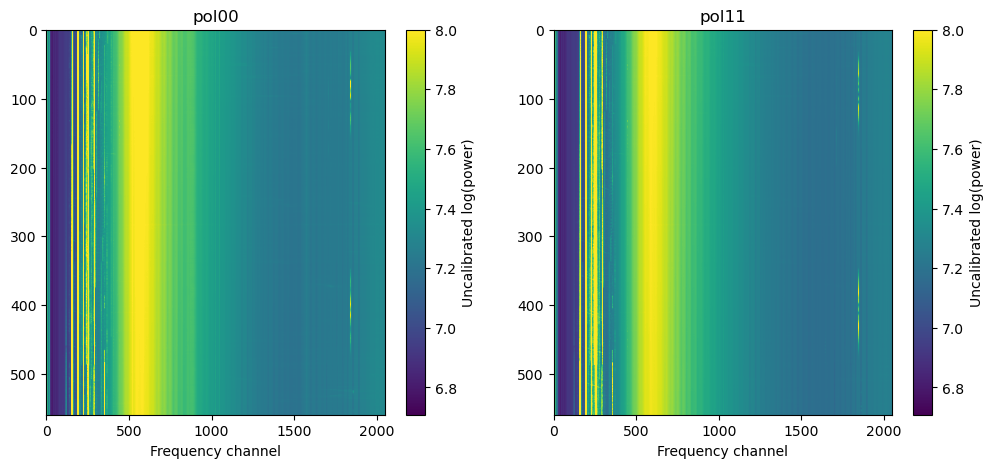

In [4]:
logpol00 = np.log10(pol00)
logpol11 = np.log10(pol11)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.title('pol00')
plt.imshow(logpol00, aspect='auto', vmax=8)
plt.xlabel('Frequency channel')
plt.colorbar(label='Uncalibrated log(power)')

plt.subplot(1,2,2)
plt.title('pol11')
plt.imshow(logpol11, aspect='auto', vmax=8)
plt.xlabel('Frequency channel')
plt.colorbar(label='Uncalibrated log(power)')

plt.show()

### Auto-spectra statistics

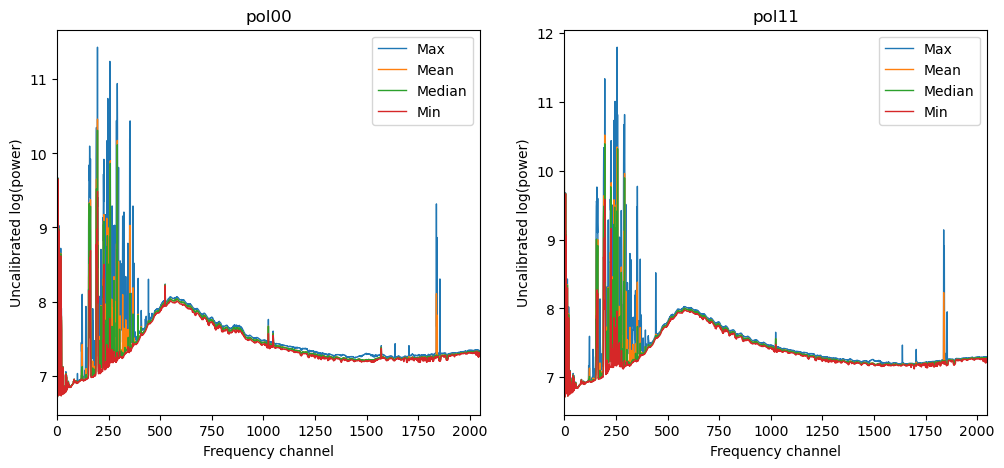

In [5]:
logpol00_max = np.log10(np.max(pol00, axis=0))
logpol00_mean = np.log10(np.mean(pol00, axis=0))
logpol00_med = np.log10(np.median(pol00, axis=0))
logpol00_min = np.log10(np.min(pol00, axis=0))

logpol11_max = np.log10(np.max(pol11, axis=0))
logpol11_mean = np.log10(np.mean(pol11, axis=0))
logpol11_med = np.log10(np.median(pol11, axis=0))
logpol11_min = np.log10(np.min(pol11, axis=0))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.title('pol00')
plt.plot(logpol00_max, label="Max", lw=1)
plt.plot(logpol00_mean, label='Mean', lw=1)
plt.plot(logpol00_med, label='Median', lw=1)
plt.plot(logpol00_min, label="Min", lw=1)
plt.xlim(0,2048)
plt.ylabel('Uncalibrated log(power)')
plt.xlabel('Frequency channel')
plt.legend()

plt.subplot(1,2,2)
plt.title('pol11')
plt.plot(logpol11_max, label="Max", lw=1)
plt.plot(logpol11_mean, label='Mean', lw=1)
plt.plot(logpol11_med, label='Median', lw=1)
plt.plot(logpol11_min, label="Min", lw=1)
plt.xlim(0,2048)
plt.ylabel('Uncalibrated log(power)')
plt.xlabel('Frequency channel')
plt.legend()

plt.show()

### Cross-spectra waterfall plots

#### Magnitude and phase

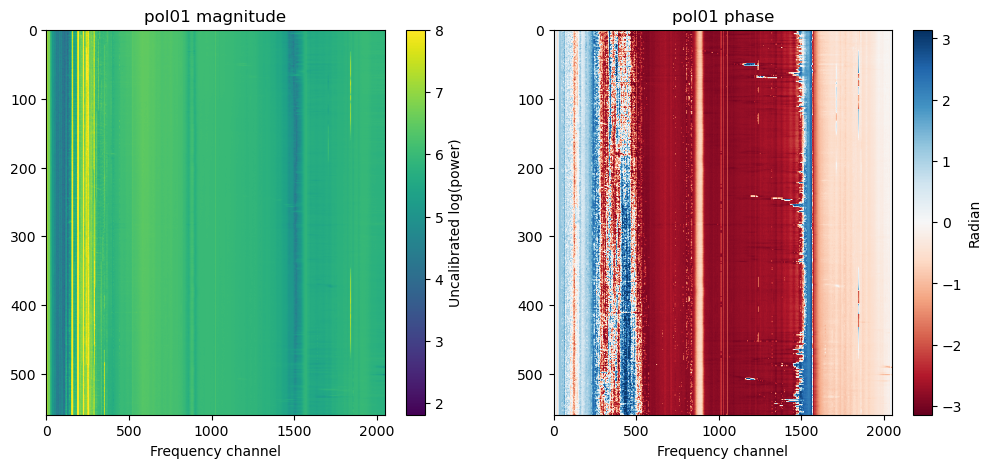

In [6]:
logpol01 = np.log10(np.abs(pol01))
pol01_phase = np.angle(pol01)


plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.title('pol01 magnitude')
plt.imshow(logpol01, aspect='auto', vmax=8)
plt.xlabel('Frequency channel')
plt.colorbar(label='Uncalibrated log(power)')

plt.subplot(1,2,2)
plt.title('pol01 phase')
plt.imshow(pol01_phase, aspect='auto', vmin=-np.pi, vmax=np.pi, cmap='RdBu')
plt.xlabel('Frequency channel')
plt.colorbar(label='Radian')

plt.show()

### Combining many days of observations (basic method)

A really basic method for appending a bunch of direct spectra files together using `SNAPfiletools.readin_append()`. It would also be possible to use `scio.read_files()` for this task instead.

See `plot_overnight_new.py` for fancier concatenation/averaging/etc of direct spectra. It's a nice script that does a lot of work under the hood.

In [7]:
from albatros_analysis import SNAPfiletools as sft

In [8]:
# Choose start and end timestamps
ctime_start = 1640100000
ctime_stop = 1640300000

# Find all direct data subdirectories between the desired start and stop times
data_subdirs = sft.time2fnames(ctime_start, ctime_stop, data_dir)
print(f"Found {len(data_subdirs)} subdirectories between {ctime_start} and {ctime_stop}.")

# Get the direct spectra from all data subdirectories and append them together
pol00 = sft.readin_append(data_subdirs, "", "pol00.scio.bz2", scio.read) # in this case use empty string as base_file_path because data_subdirs already gives full relative path to subdirectories
pol01r = sft.readin_append(data_subdirs, "", "pol01r.scio.bz2", scio.read)
pol01i = sft.readin_append(data_subdirs, "", "pol01i.scio.bz2", scio.read)
pol11 = sft.readin_append(data_subdirs, "", "pol11.scio.bz2", scio.read)

pol01 = pol01r + 1J*pol01i

Found 35 subdirectories between 1640100000 and 1640300000.


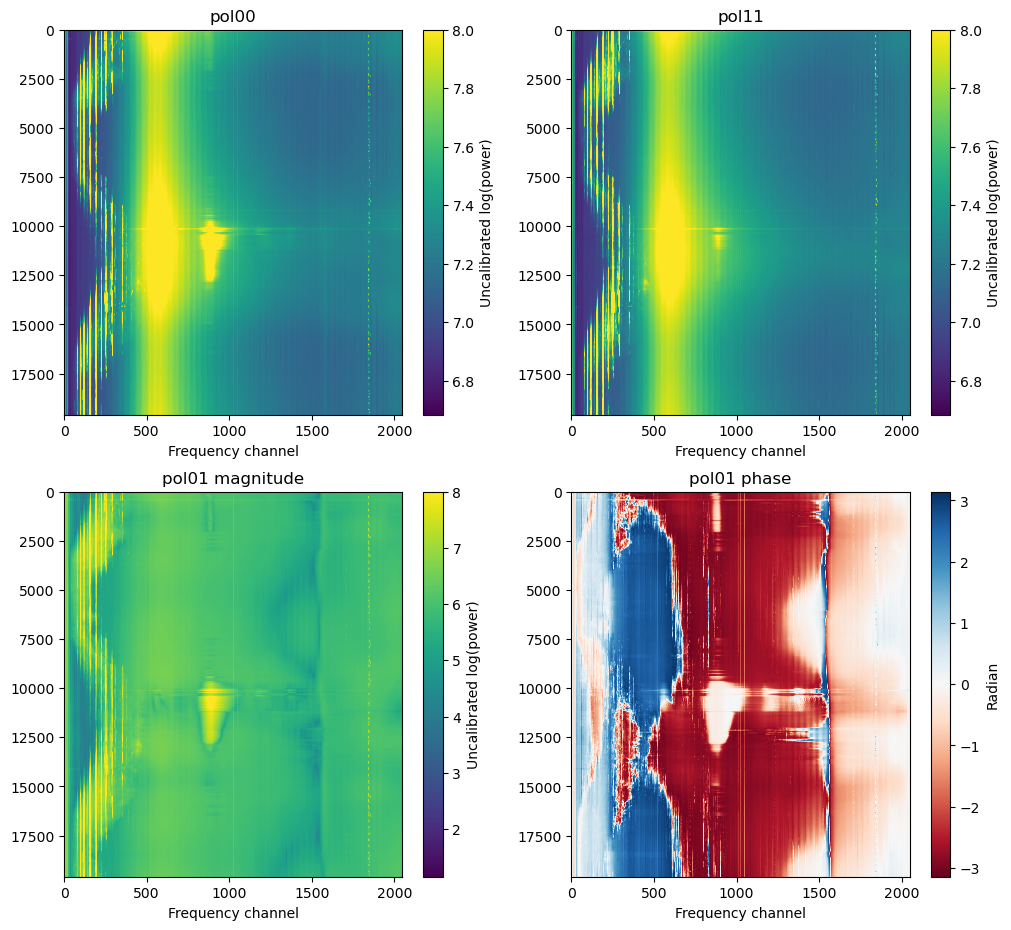

In [9]:
logpol00 = np.log10(pol00)
logpol11 = np.log10(pol11)
logpol01 = np.log10(np.abs(pol01))
pol01_phase = np.angle(pol01)

plt.figure(figsize=(12,11))

plt.subplot(2,2,1)
plt.title('pol00')
plt.imshow(logpol00, aspect='auto', vmax=8)
plt.xlabel('Frequency channel')
plt.colorbar(label='Uncalibrated log(power)')

plt.subplot(2,2,2)
plt.title('pol11')
plt.imshow(logpol11, aspect='auto', vmax=8)
plt.xlabel('Frequency channel')
plt.colorbar(label='Uncalibrated log(power)')

plt.subplot(2,2,3)
plt.title('pol01 magnitude')
plt.imshow(logpol01, aspect='auto', vmax=8)
plt.xlabel('Frequency channel')
plt.colorbar(label='Uncalibrated log(power)')

plt.subplot(2,2,4)
plt.title('pol01 phase')
plt.imshow(pol01_phase, aspect='auto', vmin=-np.pi, vmax=np.pi, cmap='RdBu')
plt.xlabel('Frequency channel')
plt.colorbar(label='Radian')

plt.show()

## Loading auxiliary data products

Use `numpy.fromfile()` to read auxiliary data binaries.

### Time products
When the Raspberry Pi reads the FPGA registers for data, the start and stop times of this action are recorded. The difference between a start and stop time is simply the amount of time taken by the Raspberry Pi to read the data from the FPGA. It is not the accumulation time. The accumulation time is given roughly by the difference between consecutive start times (or consecutive stop times).

The Raspberry Pi's system time is logged as a float while the GPS time is logged as a 32-bit integer. Both are Unix timestamps.

In [10]:
time_sys_start = np.fromfile(os.path.join(data_path, "time_sys_start.raw"))
time_sys_stop = np.fromfile(os.path.join(data_path, "time_sys_stop.raw"))
time_gps_start = np.fromfile(os.path.join(data_path, "time_gps_start.raw"), dtype="int32")
time_gps_stop = np.fromfile(os.path.join(data_path, "time_gps_stop.raw"), dtype="int32")

### Temperature products

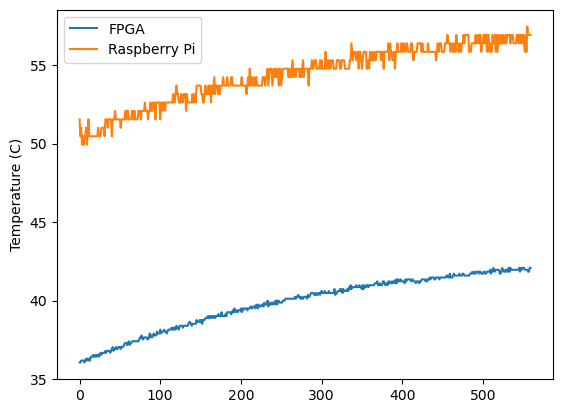

In [11]:
fpga_temp = np.fromfile(os.path.join(data_path, "fpga_temp.raw"))
pi_temp = np.fromfile(os.path.join(data_path, "pi_temp.raw"))

plt.plot(fpga_temp, label='FPGA')
plt.plot(pi_temp, label='Raspberry Pi')
plt.ylabel('Temperature (C)')
plt.legend()
plt.show()

### FPGA counters

The accumulation counters (acc_cnt[12].raw) are stored as arrays of 32-bit integers so `dtype="int32"` must be specified when reading with `numpy.fromfile()`.

The other FPGA-related counters are generally all zeros under normal conditions.

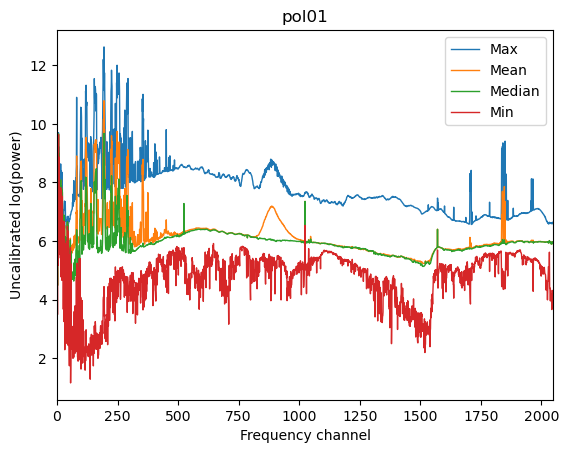

In [14]:
logpol01_max = np.log10(np.max(np.abs(pol01), axis=0))
logpol01_mean = np.log10(np.mean(np.abs(pol01), axis=0))
logpol01_med = np.log10(np.median(np.abs(pol01), axis=0))
logpol01_min = np.log10(np.min(np.abs(pol01), axis=0))

plt.title('pol01')
plt.plot(logpol01_max, label="Max", lw=1)
plt.plot(logpol01_mean, label='Mean', lw=1)
plt.plot(logpol01_med, label='Median', lw=1)
plt.plot(logpol01_min, label="Min", lw=1)
plt.xlim(0,2048)
plt.ylabel('Uncalibrated log(power)')
plt.xlabel('Frequency channel')
plt.legend()
plt.show()